In [2]:
import numpy as np
import os
import os
import tarfile
from six.moves import urllib
np.random.seed(42)

In [3]:
#Scrape Data
ROOT = "https://raw.githubusercontent.com/ageron/handson-ml/master/"
PATH = "datasets/housing"
URL = ROOT+PATH+"/housing.tgz"

def fetch_housing_data(housing_url=URL, housing_path=PATH):
    '''
    creates datasets/housing directory
    downloads and extracts file
    '''
    if not os.path.isdir(housing_path):
        os.makedirs(housing_path)
    tgz_path = os.path.join(housing_path, "housing.tgz")
    urllib.request.urlretrieve(housing_url, tgz_path)
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(path=housing_path)
    housing_tgz.close()

In [4]:
import pandas as pd
def load_data(housing_path=PATH):
    '''
    returns the dataset from above
    '''
    fetch_housing_data()
    housing_csv = os.path.join(housing_path, "housing.csv")
    return pd.read_csv(housing_csv)

In [5]:
housing_data = load_data()
housing_data.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


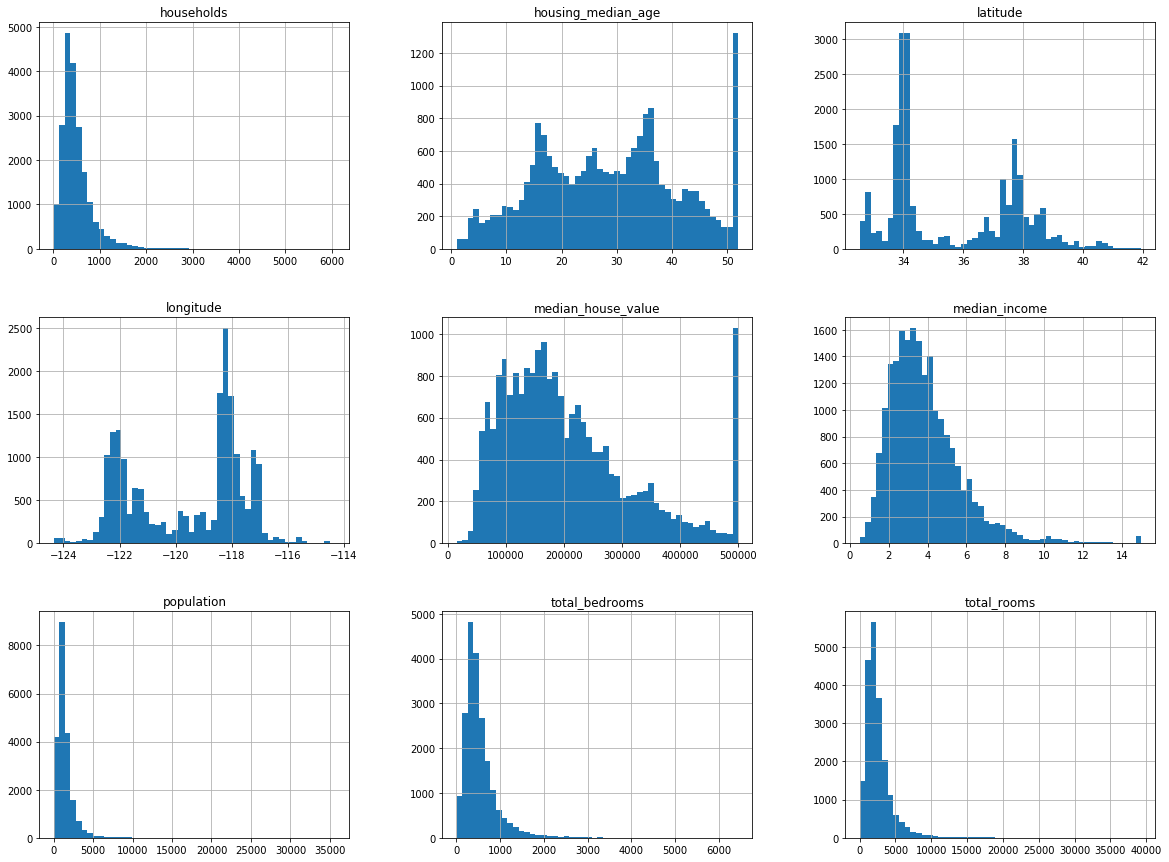

In [6]:
%matplotlib inline
import matplotlib.pyplot as plt
housing_data.hist(bins =50,figsize=(20,15))
plt.show()

In [7]:
def split_set(data, test_ratio):
    '''
    splits data set randomly with a given ratio in the test set and the rest in the training set
    returns the two sets
    '''
    shuffled_data = np.random.permutation(len(data))
    test_set_size = int(len(data)*test_ratio)
    test_set = shuffled_data[:test_set_size]
    train_set = shuffled_data[test_set_size:]
    return (data.iloc[train_set], data.iloc[test_set])

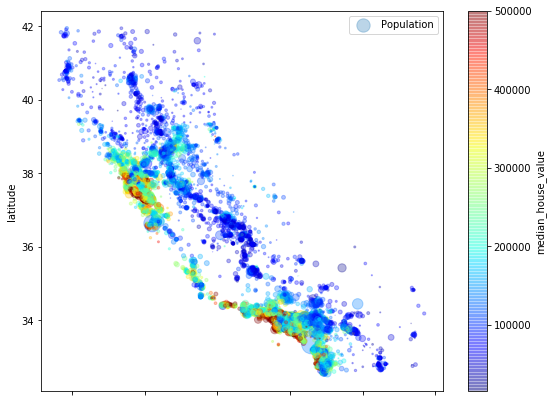

In [215]:
train_set, test_set = split_set(housing_data, .2)

#gaining data insights

housing = train_set.copy()
housing.plot(kind="scatter",
             figsize=(9,7),
             x="longitude",
             y="latitude",
             alpha=0.3,
            c="median_house_value",
            s=housing["population"]/100,
            label="Population",
            cmap=plt.get_cmap("jet"),
            colorbar=True)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a23e672b0>,
      dtype=object)

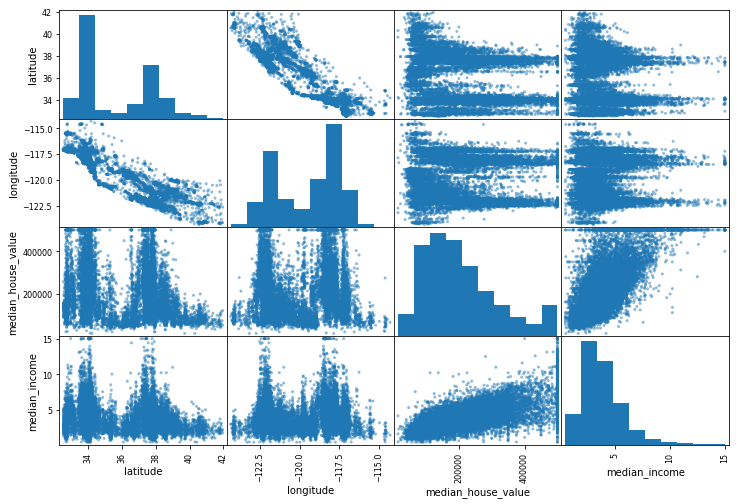

In [216]:
###
corr_matrix = housing.corr()
corr_matrix["median_house_value"].sort_values()
from pandas.plotting import scatter_matrix
attributes = ["latitude", "longitude", "median_house_value", "median_income"]
scatter_matrix(housing[attributes], figsize=(12,8))

In [222]:
housing["percent_bedrooms"]=housing["total_bedrooms"]/housing["total_rooms"]
housing["population_per_household"]=housing["population"]/housing["households"]
corr_matrix = housing.corr()
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value          1.000000
median_income               0.690030
total_rooms                 0.136493
housing_median_age          0.104915
households                  0.068055
total_bedrooms              0.051113
population_per_household   -0.022018
population                 -0.022743
longitude                  -0.044122
latitude                   -0.146729
percent_bedrooms           -0.255793
Name: median_house_value, dtype: float64

In [223]:
#preparing the data

from sklearn.preprocessing import Imputer, LabelEncoder, OneHotEncoder

housing = train_set.drop("median_house_value", axis=1)
housing_labels = train_set["median_house_value"].copy()
housing_nums = housing.drop("ocean_proximity", axis=1)

imputer = Imputer(strategy="median")
#find median values
imputer.fit(housing_nums)
#replace Nan values with said median values
x = imputer.transform(housing_nums)
housing_nums_full = pd.DataFrame(x, columns=housing_nums.columns)

#encoding labels
encoder = LabelEncoder()
housing_cat = housing["ocean_proximity"]
housing_cat_num = encoder.fit_transform(housing_cat)
#translating to 1-hot encoding (all values 0 except the one that it is which is 1, gets aroung issue of 1 being closer to 2)
encoder = OneHotEncoder()
#reshape(-1,1) means 1 element per row for x columns (the -1 means numpy figures out the columns to make this work)
housing_cat_1hot = encoder.fit_transform(housing_cat_num.reshape(-1,1))
housing_cat_1hot


<16512x5 sparse matrix of type '<class 'numpy.float64'>'
	with 16512 stored elements in Compressed Sparse Row format>

In [224]:
from sklearn.base import BaseEstimator, TransformerMixin

#building custom transformer
rooms_iloc, bedrooms_iloc, population_iloc, household_iloc = 3,4,5,6

class CombinedAttributeAdder(BaseEstimator, TransformerMixin):
    def __init__(self, add_percent_bedrooms = True):
        self.add_percent_bedrooms = add_percent_bedrooms
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        #how many rooms each house has on avg
        rooms_per_house = X[:, rooms_iloc]/ X[:, household_iloc]
        #how many people live in each household
        population_per_house = X[:,population_iloc]/X[:,household_iloc]
        if self.add_percent_bedrooms:
        #what fraction of the rooms in a house are bedrooms
            percent_bedrooms = X[:, bedrooms_iloc]/X[:, rooms_iloc]
            #convert to np array
            return np.c_[X, rooms_per_house, population_per_house, percent_bedrooms]
        else:
            return np.c_[X, rooms_per_house, population_per_house]
attadder = CombinedAttributeAdder()
housing_plus = attadder.transform(housing.values)

In [225]:
#building tool to transform between pd and np frames
class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, atrib_names):
        self.atrib_names = atrib_names
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        return X[self.atrib_names].values

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, LabelBinarizer
from sklearn.pipeline import FeatureUnion

num_attribs = list(housing_nums)
cat_attribs = ["ocean_proximity"]

#building full data pipeline using vatious transformers experimented with above
num_pipeline = Pipeline([
        ('selector', DataFrameSelector(num_attribs)),
        ('imputer', Imputer(strategy="median")),
        ('attribs_adder', CombinedAttributeAdder()),
        ('std_scaler', StandardScaler())
    ])

cat_pipeline = Pipeline([
        ('selector', DataFrameSelector(cat_attribs)),
        ('label_binarizer', LabelBinarizer()),
    ])

full_pipeline = FeatureUnion(transformer_list=[
        ("num_pipeline", num_pipeline),
        ("cat_pipeline", cat_pipeline),
    ])
housing_prepared = full_pipeline.fit_transform(housing)

#the transformed training set
clean_set = pd.DataFrame(data=housing_prepared[0:,0:],    # values
          index=range(0,housing_prepared.shape[0]),    # 1st column as index
       columns=['longitude', 'latitude', 'housing_median_age', 'total_rooms',
     'total_bedrooms', 'population', 'households', 'median_income', 'rooms_per_house','pop_per_house', 'percent_bedrooms','NEAR OCEAN', 'INLAND', '<1H OCEAN', 'NEAR BAY', 'ISLAND'])  # 1st row as the column names
clean_set.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,rooms_per_house,pop_per_house,percent_bedrooms,NEAR OCEAN,INLAND,<1H OCEAN,NEAR BAY,ISLAND
0,0.668779,-0.707478,-0.050284,-0.497932,-0.167262,-0.393951,-0.236297,-0.840487,-0.646789,-0.061629,1.348918,1.0,0.0,0.0,0.0,0.0
1,-1.101932,1.418388,0.826223,0.081941,0.305291,0.207406,0.368869,-1.002109,-0.407722,-0.043252,0.346347,0.0,1.0,0.0,0.0,0.0
2,-1.126872,0.625850,-0.767426,0.829793,0.408437,0.299585,0.476746,0.242525,0.427635,-0.043457,-0.841170,1.0,0.0,0.0,0.0,0.0
3,0.808441,-0.749436,0.348128,-0.540733,-0.500688,0.163512,-0.470470,-0.061203,-0.346183,0.167511,0.167645,1.0,0.0,0.0,0.0,0.0
4,1.182535,-1.299550,-0.528379,0.401791,0.230930,-0.110391,0.218893,0.484217,0.231343,-0.074989,-0.514551,0.0,0.0,0.0,0.0,1.0


In [226]:
#Model selection!
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error as mse

lin_reg = LinearRegression()
lin_reg.fit(housing_prepared, housing_labels)

predictions = lin_reg.predict(housing_prepared)

In [227]:
from sklearn.model_selection import cross_val_score as cvs

def display_scores(scores):
    '''
    prints a given kfold output
    '''
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())

cross = cvs(lin_reg, housing_prepared, housing_labels, scoring="neg_mean_squared_error", cv=10)
kfold_mse = np.sqrt(-cross)
display_scores(kfold_mse)

Scores: [66816.93546049 70208.2064033  74504.55973221 67145.38702518
 66932.29507044 69510.6911676  69580.58806836 66771.44671274
 70267.50779808 64339.31671843]
Mean: 68607.69341568372
Standard deviation: 2675.7156452148784


In [228]:
#data seems to be underfitted, model seems to have underfitted training data

from sklearn.tree import DecisionTreeRegressor
tree_reg = DecisionTreeRegressor()
tree_reg.fit(housing_prepared, housing_labels)

predictions = tree_reg.predict(housing_prepared)

#Trying cross validation

cross = cvs(tree_reg, housing_prepared, housing_labels, scoring="neg_mean_squared_error", cv=10)
kfold_mse = np.sqrt(-cross)
display_scores(kfold_mse)

Scores: [69007.68153571 72110.82760605 69929.1989979  68897.0275036
 71918.74471224 72854.79944702 69683.97849169 68448.39969729
 69351.56579732 71227.48847968]
Mean: 70342.97122685077
Standard deviation: 1474.8405585607647


Scores: [49389.6814003  56269.08255041 54273.6583194  50655.6465847
 54028.93134208 53231.42358476 52343.88936324 51757.51208674
 51249.33037385 52106.04733121]
Mean: 52530.52029366846
Standard deviation: 1886.4224631593581


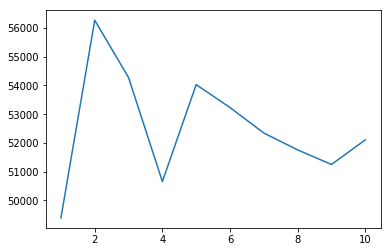

In [229]:
from sklearn.ensemble import RandomForestRegressor as rfr
forest_reg = rfr()
forest_reg.fit(housing_prepared, housing_labels)

predictions = forest_reg.predict(housing_prepared)

#Trying cross validation

cross = cvs(forest_reg, housing_prepared, housing_labels, scoring="neg_mean_squared_error", cv=10)
kfold_mse = np.sqrt(-cross)
display_scores(kfold_mse)
plt.plot(range(1,11), kfold_mse)

In [230]:
forest_reg.n_features_

16

In [231]:
#Tweaking Hyperparamaters for random forest regressor

from sklearn.model_selection import GridSearchCV as gscv

param_grid = [
    {'n_estimators': range(30, 70,10), 'max_features': range(8,18,2), 'n_jobs': [1]},
  ]
grid_search = gscv(forest_reg, param_grid, cv=3, scoring = "neg_mean_squared_error")


In [ ]:
#fitting the model
grid_search.fit(housing_prepared, housing_labels)

In [193]:
print("Acheaved score of:\t", np.sqrt(-grid_search.best_score_))
print("With following paramaters:\t", grid_search.best_params_)
print("The model:\t",grid_search.best_estimator_)

Acheaved score of:	 50065.75460918112
With following paramaters:	 {'max_features': 8, 'n_estimators': 60, 'n_jobs': 1}
The model:	 RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features=8, max_leaf_nodes=None, min_impurity_split=1e-07,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=60, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)


In [198]:
#Evaluating model on test set
final_model = rfr(bootstrap=True, criterion='mse', max_depth=None,
           max_features=8, max_leaf_nodes=None, min_impurity_split=1e-07,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=60, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)
final_model.fit(housing_prepared, housing_labels)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features=8, max_leaf_nodes=None, min_impurity_split=1e-07,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=60, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [199]:
X_test = test_set.drop("median_house_value", axis=1)
y_test = test_set["median_house_value"].copy()
X_test_prep = full_pipeline.transform(X_test)# transform instead of fit transform bc dont want to change how these values are scaled, want to use same scalaing perams as on test set
predictions = final_model.predict(X_test_prep)
final_mse = mse(y_test, predictions)
np.sqrt(final_mse)

49002.490198827334

In [200]:
#Trying out a Vector Machine regressor for kicks
from sklearn.svm import SVR
vect_regressor = SVR()
vect_regressor.fit(housing_prepared, housing_labels)

SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='auto',
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

In [201]:
predictions = vect_regressor.predict(housing_prepared)

In [202]:
vect_cross = cvs(vect_regressor, housing_prepared, housing_labels, scoring="neg_mean_squared_error", cv=2)
kfold_mse_vect = np.sqrt(-vect_cross)
display_scores(kfold_mse_vect)

vect_regressor.get_params()

Scores: [118891.15119303 118323.17177166]
Mean: 118607.16148234296
Standard deviation: 283.98971068239916


{'C': 1.0,
 'cache_size': 200,
 'coef0': 0.0,
 'degree': 3,
 'epsilon': 0.1,
 'gamma': 'auto',
 'kernel': 'rbf',
 'max_iter': -1,
 'shrinking': True,
 'tol': 0.001,
 'verbose': False}

In [207]:
from sklearn.model_selection import RandomizedSearchCV as rscv
param_grid = {'kernel': ['linear', 'rbf'], 'C': range(20,60,10), 'gamma': ['auto', 20, 40, 60, 80]}
random_search = rscv(vect_regressor, param_grid, cv=5, scoring = "neg_mean_squared_error")

In [208]:
#fitting the model
random_search.fit(housing_prepared, housing_labels)

RandomizedSearchCV(cv=5, error_score='raise',
          estimator=SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='auto',
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False),
          fit_params={}, iid=True, n_iter=10, n_jobs=1,
          param_distributions={'kernel': ['linear', 'rbf'], 'C': range(20, 60, 10), 'gamma': ['auto', 20, 40, 60, 80]},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score=True, scoring='neg_mean_squared_error',
          verbose=0)

In [210]:
print("Acheaved score of:\t", np.sqrt(-random_search.best_score_))
print("With following paramaters:\t", random_search.best_params_)
print("The model:\t",random_search.best_estimator_)

Acheaved score of:	 72245.2880073903
With following paramaters:	 {'kernel': 'linear', 'gamma': 'auto', 'C': 50}
The model:	 SVR(C=50, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='auto',
  kernel='linear', max_iter=-1, shrinking=True, tol=0.001, verbose=False)
